In [38]:
import numpy as np
import torch
import torch.nn as nn
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True

setup_seed(2022311328)

In [40]:
class MLP(nn.Module):
    def __init__(self,m,input,output):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,output)
        )
    def forward(self, x):
        return self.net(x)

In [41]:
class ResNet(nn.Module):
    def __init__(self,m,input,out):
        super(ResNet, self).__init__()
        self.input = nn.Linear(input,m)
        self.block1=nn.Sequential(
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
        )
        self.block2=nn.Sequential(
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
        )
        self.block3=nn.Sequential(
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
        )
        self.block4=nn.Sequential(
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
        )
        self.block5=nn.Sequential(
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
        )
        self.block6=nn.Sequential(
            nn.Linear(m,m),nn.Tanh(),
            nn.Linear(m,m),nn.Tanh(),
        )
        self.out = nn.Linear(m,out)
    def forward(self, x):
        x = self.input(x)
        x = self.block1(x) + x
        x = self.block2(x) + x
        x = self.block3(x) + x
        x = self.block4(x) + x
        x = self.block5(x) + x
        x = self.block6(x) + x
        x = self.out(x)
        return x

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
beta = torch.tensor(0.4166666666666e-1).to(device)
gamma = torch.tensor([-0.6032109664493744, 0.518812338640025, 0, 0.73866830872157e+1, -0.7225370982867850]).to(device)
gamma_inv = torch.flip(gamma, dims=[0]).to(device)

In [43]:
#边界条件，真值
def g(x,a):
    return torch.exp(x[:,0]*a)*torch.sin(x[:,1]*a)

In [44]:
def loss_binet(net,bd,y,W):
    res = torch.mean(torch.pow((W@net(y)-bd),2))
    return res

In [45]:
def loss_pinn(net,bd,x_in,x_bd):
    res = torch.mean(torch.pow(net(x_bd)-bd,2)).to(device)
    partial = torch.autograd.grad(net(x_in), x_in, torch.ones_like(net(x_in)).to(device), create_graph=True)[0]
    partial_11 = torch.autograd.grad(partial[:,0], x_in, torch.ones_like(partial[:,0]).to(device), create_graph=True)[0][:,0]
    partial_22 = torch.autograd.grad(partial[:,1], x_in, torch.ones_like(partial[:,0]).to(device), create_graph=True)[0][:,1]
    res += torch.mean(torch.pow(partial_11+partial_22,2))
    return res

In [46]:
num_epoch = 10000
m = 50
lr = 1e-4
M = 200
a = 4
n_bd = 200
n_in = 1600

In [47]:
net_binet = ResNet(m,2,1).to(device)

optim = torch.optim.Adam(net_binet.parameters(), lr = lr)

error_binet = torch.zeros(num_epoch)

#矩形区域，顶点为[-1,-1],[-1,1],[1,1],[1,-1]
vertex = torch.tensor([[-1,-1],[-1,1],[1,1],[1,-1],[-1,-1]]).to(device)
h = 2/M

#积分节点
y = torch.zeros(4*M,2).to(device)
for i in range(4):
    y[i*M:i*M+M,:] = vertex[i,:]+(vertex[i+1,:]-vertex[i,:])*(torch.linspace(0,1-1/M,M).reshape(-1,1).to(device))
sample_num = len(y)

#积分权重
W = torch.zeros(sample_num,sample_num).to(device)
for i in range(sample_num):
    if (i%M != 0) and (i%M != 1) and (i%M != M-1) and (i%M != M-2):
        r = (y - y[i,:]).norm(dim=1)
        W[i,:] = 1/(2*np.pi)*h*torch.log(r)
        k = math.floor(i/M)
        W[i,k*M] *= beta
        W[i,k*M+1] *= 1/2
        W[i,k*M+2] *= 1-beta
        W[i,i-2:i+3] += 1/(2*np.pi)*h*torch.log(r)[i-2:i+3]*(gamma_inv+gamma)
        W[i,k*M+M-1] += 1/(2*np.pi)*h*torch.log(r)[k*M+M-1]*beta
        W[i,k*M+M-2] -= 1/(2*np.pi)*h*torch.log(r)[k*M+M-2]/2
        W[i,k*M+M-3] -= 1/(2*np.pi)*h*torch.log(r)[k*M+M-3]*beta
        W[i,i] = 0

index_save = torch.tensor([i for i in range(len(y)) if (i%M != 0) and (i%M != 1) and (i%M != M-1) and (i%M != M-2)]).to(device)
W = torch.index_select(W,0,index_save)

#边界条件
y_new = torch.index_select(y,0,index_save)
bd = g(y_new,a).reshape(len(y_new),1).to(device)

for epoch in range(num_epoch):
    l = loss_binet(net_binet,bd,y,W)
    with torch.no_grad():
        error_binet[epoch] = l
    if l<1e-3:
        break
    optim.zero_grad()
    l.backward()
    optim.step()

epoch_binet = epoch
print(loss_binet(net_binet,bd,y,W))
print(error_binet[0:epoch+1].min())

tensor(0.6938, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6943)


In [48]:
net_binet2 = ResNet(m,2,1).to(device)

optim = torch.optim.Adam(net_binet2.parameters(), lr = lr)

error_binet2 = torch.zeros(num_epoch)

#矩形区域，顶点为[-1,-1],[-1,1],[1,1],[1,-1]
vertex = torch.tensor([[-1.,-1],[-1.,1],[1.,1],[1.,-1],[-1.,-1]]).to(device)
h = 2/M

normal = torch.zeros(4,2).to(device)     
for i in range(4):
    normal[i,:] = (vertex[i+1,:]-vertex[i,:])@torch.Tensor([[0,1],[-1,0]]).to(device)
    normal[i,:] = normal[i,:]/(normal[i,:].norm())

#积分节点
y2 = torch.zeros(4*M,2).to(device)
for i in range(4):
    y2[i*M:i*M+M,:] = vertex[i,:]+(vertex[i+1,:]-vertex[i,:])*(torch.linspace(0,1-1/M,M).reshape(-1,1).to(device))
sample_num = len(y2)

#积分权重
W2 = torch.zeros(sample_num,sample_num).to(device)
j = [math.floor(j/M) for j in range(sample_num) ]
for i in range(sample_num):
    r = y2 - y2[i,:]
    d = r.norm(dim=1)
    W2[i,:] = 1/(2*np.pi)*h*(r*normal[j]).sum(axis=1)/(d*d)
    W2[i,i] = 1/2 

#边界条件
bd = g(y2,a).reshape(len(y2),1).to(device)

for epoch in range(num_epoch):
    l = loss_binet(net_binet2,bd,y2,W2)
    with torch.no_grad():
        error_binet2[epoch] = l
    if l<1e-3:
        break
    optim.zero_grad()
    l.backward()
    optim.step()

epoch_binet2 = epoch
print(loss_binet(net_binet2,bd,y2,W2))
print(error_binet2[0:epoch+1].min())

tensor(0.3421, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.3428)


In [49]:
net_pinn = ResNet(m,2,1).to(device)

optim = torch.optim.Adam(net_pinn.parameters(), lr = lr)

error_pinn = torch.zeros(num_epoch)

vertex = torch.tensor([[-1,-1],[-1,1],[1,1],[1,-1],[-1,-1]]).to(device)
x_bd = torch.zeros(4*n_bd,2).to(device)
for i in range(4):
    x_bd[i*n_bd:i*n_bd+n_bd,:] = vertex[i,:]+(vertex[i+1,:]-vertex[i,:])*(torch.linspace(0,1-1/n_bd,n_bd).reshape(-1,1).to(device))
bd = g(x_bd,a).reshape(len(x_bd),1).to(device)


x_in = torch.rand(n_in, 2)*2-1

x_in.requires_grad = True
x_in = x_in.to(device)

for epoch in range(num_epoch):
    l = loss_pinn(net_pinn,bd,x_in,x_bd)
    with torch.no_grad():
        error_pinn[epoch] = l
    if epoch%1000==0:
        print('epoch:',epoch,'loss:',l)
    if l<1e-3:
        break
    optim.zero_grad()
    l.backward()
    optim.step()

epoch_pinn = epoch
print(loss_pinn(net_pinn,bd,x_in,x_bd))
print(error_pinn[0:epoch+1].min())

epoch: 0 loss: tensor(379.8837, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 1000 loss: tensor(104.5952, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 2000 loss: tensor(49.4719, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 3000 loss: tensor(27.9569, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 4000 loss: tensor(19.7727, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 5000 loss: tensor(15.1180, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 6000 loss: tensor(16.3682, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 7000 loss: tensor(9.3600, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 8000 loss: tensor(7.3844, device='cuda:0', grad_fn=<AddBackward0>)
epoch: 9000 loss: tensor(8.8559, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.4996, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5007)


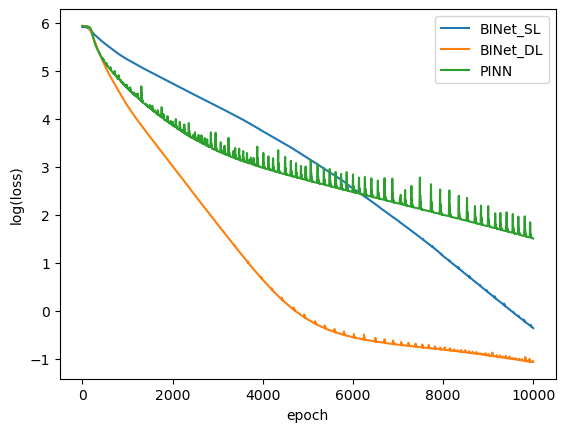

In [50]:
plt.plot(np.arange(epoch_binet+1),np.log(error_binet[0:epoch_binet+1]),label='BINet_SL')
plt.plot(np.arange(epoch_binet2+1),np.log(error_binet2[0:epoch_binet2+1]),label='BINet_DL')
plt.plot(np.arange(epoch_pinn+1),np.log(error_pinn[0:epoch_pinn+1]),label='PINN')
plt.xlabel('epoch')
plt.ylabel('log(loss)')
plt.legend()
plt.show()

In [51]:
def solve_binet(x,net,y,h):
    W = torch.zeros(len(x),len(y))
    for i in range(len(x)):
        r = (y - x[i,:]).norm(dim=1).reshape(1,len(y))
        W[i,:] = 1/(2*np.pi)*h*torch.log(r)
    W=torch.tensor(W, dtype=torch.float32)
    res = W@net(y)
    
    return res

In [52]:
def solve_binet2(x,net,y,h):
    W = torch.zeros(len(x),len(y))
    for i in range(len(x)):
       r = y - x[i,:]
       d = r.norm(dim=1)
       W[i,:] = 1/(2*np.pi)*h*(r*normal[j].to('cpu')).sum(axis=1)/(d*d)
    W=torch.tensor(W, dtype=torch.float32)
    res = W@net(y)
    
    return res 

C:\Users\GG\AppData\Local\Temp\ipykernel_22452\439141786.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W=torch.tensor(W, dtype=torch.float32)


tensor(0.4314, grad_fn=<DivBackward0>)


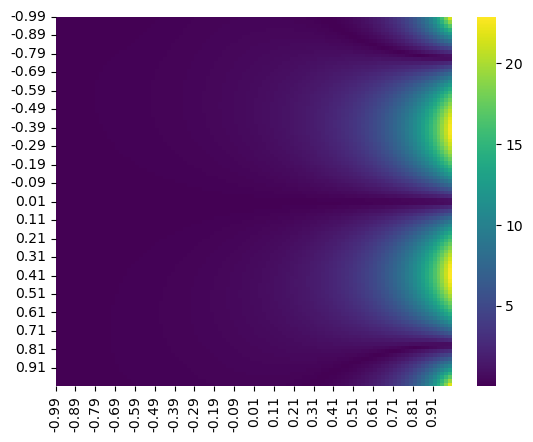

In [53]:
n_test = 100
x1_test, x2_test = np.meshgrid(np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test),
                                np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test))

inputs = np.stack([x1_test, x2_test], axis=-1)
inputs = torch.tensor(inputs, dtype=torch.float32).view(-1, 2)

net_binet = net_binet.to('cpu')
y = y.to('cpu')

outputs = torch.abs(solve_binet(inputs, net_binet, y, h) - g(inputs, a).view(-1,1))

output = outputs.view(n_test, n_test).to('cpu').detach().numpy()
print((solve_binet(inputs, net_binet, y, h) - g(inputs, a).view(-1,1)).norm() / g(inputs, a).norm())

label_interval = 5
label = np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test)[::label_interval]
label = [f'{label_val:.2f}' for label_val in label]

sns.heatmap(output, cmap='viridis', xticklabels=label, yticklabels=label)

plt.xticks(np.arange(0, n_test, label_interval), labels=label)
plt.yticks(np.arange(0, n_test, label_interval), labels=label)
plt.show()

C:\Users\GG\AppData\Local\Temp\ipykernel_22452\2833920434.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  W=torch.tensor(W, dtype=torch.float32)


tensor(0.0045, grad_fn=<DivBackward0>)


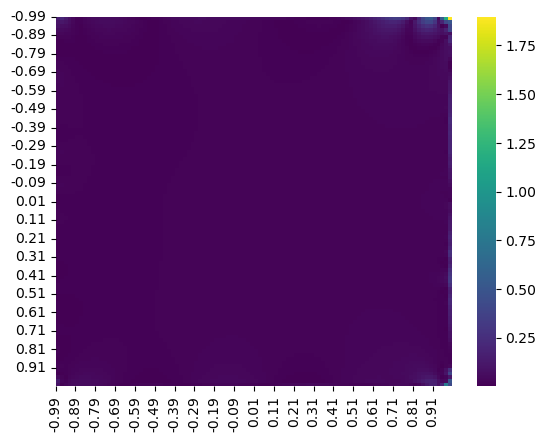

In [54]:
n_test = 100
x1_test, x2_test = np.meshgrid(np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test),
                                np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test))

inputs = np.stack([x1_test, x2_test], axis=-1)
inputs = torch.tensor(inputs, dtype=torch.float32).view(-1, 2)

net_binet2 = net_binet2.to('cpu')
y2 = y2.to('cpu')

outputs = torch.abs(solve_binet2(inputs, net_binet2, y2, h) - g(inputs, a).view(-1,1))

output = outputs.view(n_test, n_test).to('cpu').detach().numpy()
print((solve_binet2(inputs, net_binet2, y2, h) - g(inputs, a).view(-1,1)).norm() / g(inputs, a).norm())

label_interval = 5
label = np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test)[::label_interval]
label = [f'{label_val:.2f}' for label_val in label]

sns.heatmap(output, cmap='viridis', xticklabels=label, yticklabels=label)

plt.xticks(np.arange(0, n_test, label_interval), labels=label)
plt.yticks(np.arange(0, n_test, label_interval), labels=label)
plt.show()

tensor(0.0813, grad_fn=<DivBackward0>)


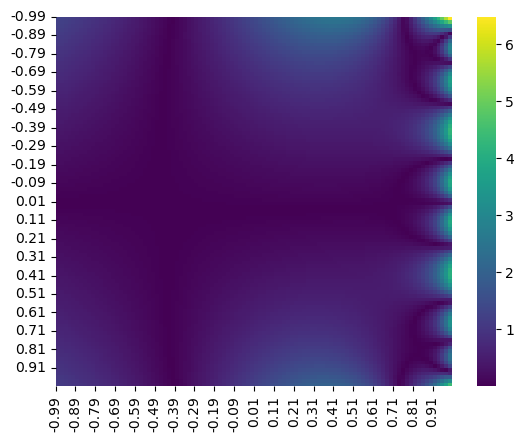

In [55]:
n_test = 100
x1_test, x2_test = np.meshgrid(np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test),
                                np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test))

inputs = np.stack([x1_test, x2_test], axis=-1)
inputs = torch.tensor(inputs, dtype=torch.float32).view(-1, 2)

net_pinn = net_pinn.to('cpu')

outputs = torch.abs(net_pinn(inputs) - g(inputs, a).view(-1,1))

output = outputs.view(n_test, n_test).to('cpu').detach().numpy()
print((net_pinn(inputs) - g(inputs, a).view(-1,1)).norm() / g(inputs, a).norm())

label_interval = 5
label = np.linspace(-1 + 1/n_test, 1 - 1/n_test, n_test)[::label_interval]
label = [f'{label_val:.2f}' for label_val in label]

sns.heatmap(output, cmap='viridis', xticklabels=label, yticklabels=label)

plt.xticks(np.arange(0, n_test, label_interval), labels=label)
plt.yticks(np.arange(0, n_test, label_interval), labels=label)
plt.show()